In [1]:
import argparse
import numpy as np
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from model_MDGCRN.MDGCRNAdjHiDD import MDGCRNAdjHiDD
from model_MDGCRN.utils import load_adj
import torch
import pickle
import os
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_data(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

dataset='METRLA'
trainval_ratio=0.8
val_ratio=0.125
num_nodes=207
seq_len=12
horizon=12
input_dim=1
output_dim=1
embed_dim=10
max_diffusion_step=3
rnn_layers=1
rnn_units=128
mem_num=20
mem_dim=64
loss='mask_mae_loss'
epochs=200
patience=30
batch_size=64
lr=0.01
steps=[50, 100]
lr_decay_ratio=0.1
weight_decay=0
epsilon=0.001
max_grad_norm=5
use_curriculum_learning=True
adj_type='symadj'
cl_decay_steps=2000
gpu=1
seed=888
temp=1.0
lamb=0.1
lamb1=0.0
lamb2=1.0
contra_loss='infonce'
compact_loss='mse'
detect_loss='mae'
use_mask=False
use_STE=False
data_path = f'./{dataset}/metr-la.h5'
adj_mx_path = f'./{dataset}/adj_mx.pkl'
num_nodes = 207
device = torch.device("cuda:0")

steps = [10, 150]
model_name = 'MDGCRNAdjHiDD'
cpu_num = 1
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed(seed)

In [2]:
modelpt_path=f'LA_fixD.pt'
# modelpt_path_woC=f'./{dataset}/LA_woC.pt'
# modelpt_path_woD=f'./{dataset}/LA_woD.pt'
# modelpt_path_woCD=f'./{dataset}/LA_woCD.pt'

In [3]:
class StandardScaler():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean

data = {}
for category in ['train', 'val', 'test']:
    cat_data = np.load(os.path.join(f'./METRLA', category + 'his.npz'))
    data['x_' + category] = np.nan_to_num(cat_data['x']) if True in np.isnan(cat_data['x']) else cat_data['x']
    data['y_' + category] = np.nan_to_num(cat_data['y']) if True in np.isnan(cat_data['y']) else cat_data['y']
scaler = StandardScaler(mean=data['x_train'][..., 0].mean(), std=data['x_train'][..., 0].std())
for category in ['train', 'val', 'test']:
    data['x_' + category][..., 0] = scaler.transform(data['x_' + category][..., 0])
    
diff_max = np.max(np.abs(scaler.transform(data['x_train'][..., 0]) - scaler.transform(data['x_train'][..., -1])))  # 3.734067777528973 for x_train, x_val, and x_test
diff_min = 0.

print(data.keys())
print(scaler.mean)
print(scaler.std)
print(diff_max)

dict_keys(['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test'])
54.40592829587626
19.493739270573094
3.734067777528973


In [4]:
adj_mx = load_adj(adj_mx_path, adj_type)
adjs = [torch.FloatTensor(i).to(device) for i in adj_mx]

model = MDGCRNAdjHiDD(num_nodes=num_nodes, input_dim=input_dim, output_dim=output_dim, horizon=horizon, 
                 rnn_units=rnn_units, rnn_layers=rnn_layers, cheb_k = max_diffusion_step, mem_num=mem_num, 
                 mem_dim=mem_dim, embed_dim=embed_dim, adj_mx = adjs, cl_decay_steps=cl_decay_steps, use_curriculum_learning=use_curriculum_learning, 
                 contra_loss=contra_loss, diff_max=diff_max, diff_min=diff_min, use_mask=use_mask, use_STE=use_STE, device=device).to(device)
# model_woC = MDGCRNAdjHiDD(num_nodes=num_nodes, input_dim=input_dim, output_dim=output_dim, horizon=horizon, 
#                  rnn_units=rnn_units, rnn_layers=rnn_layers, cheb_k = max_diffusion_step, mem_num=mem_num, 
#                  mem_dim=mem_dim, embed_dim=embed_dim, adj_mx = adjs, cl_decay_steps=cl_decay_steps, use_curriculum_learning=use_curriculum_learning, 
#                  contra_loss=contra_loss, diff_max=diff_max, diff_min=diff_min, use_mask=use_mask, use_STE=use_STE, device=device).to(device)
# model_woD = MDGCRNAdjHiDD(num_nodes=num_nodes, input_dim=input_dim, output_dim=output_dim, horizon=horizon, 
#                  rnn_units=rnn_units, rnn_layers=rnn_layers, cheb_k = max_diffusion_step, mem_num=mem_num, 
#                  mem_dim=mem_dim, embed_dim=embed_dim, adj_mx = adjs, cl_decay_steps=cl_decay_steps, use_curriculum_learning=use_curriculum_learning, 
#                  contra_loss=contra_loss, diff_max=diff_max, diff_min=diff_min, use_mask=use_mask, use_STE=use_STE, device=device).to(device)
# model_woCD = MDGCRNAdjHiDD(num_nodes=num_nodes, input_dim=input_dim, output_dim=output_dim, horizon=horizon, 
#                  rnn_units=rnn_units, rnn_layers=rnn_layers, cheb_k = max_diffusion_step, mem_num=mem_num, 
#                  mem_dim=mem_dim, embed_dim=embed_dim, adj_mx = adjs, cl_decay_steps=cl_decay_steps, use_curriculum_learning=use_curriculum_learning, 
#                  contra_loss=contra_loss, diff_max=diff_max, diff_min=diff_min, use_mask=use_mask, use_STE=use_STE, device=device).to(device)

model.load_state_dict(torch.load(modelpt_path,map_location=device), strict=False)
# model_woC.load_state_dict(torch.load(modelpt_path_woC,map_location=device), strict=False)
# model_woD.load_state_dict(torch.load(modelpt_path_woD,map_location=device), strict=False)
# model_woCD.load_state_dict(torch.load(modelpt_path_woCD,map_location=device), strict=False)

<All keys matched successfully>

In [5]:
def prepare_x_y(x, y):
    """
    :param x: shape (batch_size, seq_len, num_sensor, input_dim)
    :param y: shape (batch_size, horizon, num_sensor, input_dim)
    :return1: x shape (seq_len, batch_size, num_sensor, input_dim)
              y shape (horizon, batch_size, num_sensor, input_dim)
    :return2: x: shape (seq_len, batch_size, num_sensor * input_dim)
              y: shape (horizon, batch_size, num_sensor * output_dim)
    """
    x0 = x[..., 0:1]
    x1 = x[..., 1:2]
    x2 = x[..., 2:3]  
    y0 = y[..., 0:1]
    y1 = y[..., 1:2]
    y2 = y[..., 2:3]
    return x0, x1, x2, y0, y1, y2 # x, x_cov, y, y_cov

In [6]:
from datetime import datetime, timedelta
import matplotlib.font_manager as fm

font = fm.FontProperties(family='Times New Roman', size=15)
font2 = fm.FontProperties(family='Times New Roman', size=15)
def add_n_minutes(base_date, n):
    # 将输入的日期字符串转换为datetime对象
    base_datetime = datetime.strptime(base_date, '%Y-%m-%d %H:%M:%S')

    # 创建一个timedelta对象，表示n * 5分钟
    delta_minutes = n * 5
    delta = timedelta(minutes=delta_minutes)

    # 将delta添加到base_datetime上，得到新的datetime对象
    result_datetime = base_datetime + delta

    return result_datetime

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def draw_pred(Test_length,node_index,date_index,test_input,y_pred,y,data):
    Test_length=Test_length
    node_index=node_index
    
    base_date_str = '2012-03-01 00:00:00'
    best_start_index=date_index
    best_sensor=node_index
    result_datetime1 = [add_n_minutes(base_date_str, i)  for i in range(best_start_index-Test_length,best_start_index+Test_length)]
    plt.figure(figsize=(6, 3))
    pred=np.concatenate((test_input[0,:,node_index,0],y_pred[0,:,best_sensor,0]))
    y_true=np.concatenate((test_input[0,:,node_index,0],y[0,:,best_sensor,0]))
    his_true=np.concatenate((data["x_train"][date_index,:,best_sensor,2],data["x_train"][date_index+Test_length,:,best_sensor,2]))
    
    plt.plot(result_datetime1,pred,color=  "#cfafd4",linewidth=4, label=f"Y Pred")  # 第一组数据
    plt.plot(result_datetime1,y_true,color= "#74aed4",linewidth=4, label=f"Y  True")  # 第一组数据
    plt.plot(result_datetime1,his_true,color= "#78c679",linewidth=4, label=f"Y  His")  # 第一组数据
    
    
    # plt.plot(result_datetime1,y_pred[0,:,best_sensor,0],color=  "#cfafd4",linewidth=4, label=f"Y Pred")  # 第一组数据
    # plt.plot(result_datetime1,y[0,:,best_sensor,0],color= "#74aed4",linewidth=4, label=f"Y  True")  # 第一组数据
    # plt.plot(result_datetime1,data["x_train"][date_index+Test_length,:,best_sensor,2],color= "#78c679",linewidth=4, label=f"Y  His")  # 第一组数据
    plt.grid(axis='both', linestyle='-.', color='#252525', linewidth=1.5)
    plt.ylabel('Speed', fontsize = 20)
    
    plt.xticks(rotation=15)  # 旋转刻度标签以适应较小的空间
    plt.tight_layout() 
    new_x_ticks=result_datetime1[::8]
        # new_x_ticks[0]=add_n_minutes(base_date_str, 288*6+24)
        # new_x_ticks[-1]=add_n_minutes(base_date_str, 288*6+240)
    new_y_ticks = np.arange(0, 100, 10)  # 设置新的刻度值
    plt.xticks(new_x_ticks)
    plt.yticks(new_y_ticks)
    #     print(new_x_ticks)
    plt.legend(fontsize=10)
    ax=plt.gca()
        # plt.axhline(0, color='black', linewidth=0.8, linestyle='dashed')
        
        # ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))  # 主刻度为每小时
        # ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter( '%m-%d %H:%M'))  # 设置主刻度标签的显示格式
    for label in ax.get_xticklabels():
        label.set_fontproperties(font2)
            
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)
        # plt.savefig('../Figure_save/Fig1b.png',dpi=600, bbox_inches='tight')
    plt.show()

In [8]:
def draw_hid(mask,pos,query,neg,node_index):
    mask=mask.squeeze().cpu().detach()
    pos=pos.squeeze().cpu().detach()
    query=query.squeeze().cpu().detach()
    neg=neg.squeeze().cpu().detach()
    
    mask_t=mask[:1,node_index,:]
    mask_his=mask[1:,node_index,:]
    pos_t=pos[:1,node_index,:]
    pos_his=pos[1:,node_index,:]
    query_t=query[:1,node_index,:]
    query_his=query[1:,node_index,:]
    neg_t=neg[0,node_index,:,:]
    neg_his=neg[1,node_index,:,:]
    neg_t=np.concatenate((neg_t,query_t,query_his))
    neg_his=np.concatenate((neg_his,pos_t,pos_his))
    # print(query_t)
    # print(query_his)
    draw_tsne(neg_t,mask_t,mask_his)
    
def draw_tsne(neg_t,mask_t,mask_his):
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    mask__t_index = torch.nonzero(mask_t[0]).item()
    mask__his_index = torch.nonzero(mask_his[0]).item()
    tsne = TSNE(n_components=2, perplexity=2, random_state=42)
    tsne_result = tsne.fit_transform(neg_t)
    
    # 创建一个散点图，为第21个点使用特殊颜色
    plt.figure(figsize=(6, 6))
    
    # 绘制前20个点
    plt.scatter(tsne_result[:20, 0], tsne_result[:20, 1], c='#E3716e', label='Meta Nodes')
    if mask__t_index==mask__his_index:
        print("T and His share the same Meta Node.")
        plt.scatter(tsne_result[mask__t_index, 0], tsne_result[mask__t_index, 1],s=200, c='#BDD7EE', label='Meta Node for T and His')
    else:
        print("T and His have different Meta Node.")
        plt.scatter(tsne_result[mask__t_index, 0], tsne_result[mask__t_index, 1],s=300, c='#F8CBAD', label='Meta Node for T ')    
        plt.scatter(tsne_result[mask__his_index, 0], tsne_result[mask__his_index, 1],s=300, c='#BDD7EE', label='Meta Node for His')    
    plt.scatter(tsne_result[20, 0], tsne_result[20, 1], s=200,c='#54BEAA', label='Query T')
    plt.scatter(tsne_result[21, 0], tsne_result[21, 1], s=200,c='#F7DEB7', label='Query His')
    
    plt.title('t-SNE of 64-dimensional Data')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

def draw_all(date_index,node_index,data,model_use,scaler):
    date_index=date_index-12
    test_input=data["x_train"][date_index:date_index+1,:,:,:]
    test_input=torch.from_numpy(test_input).float().to(device)
    # print(test_input.dtype)
    # S, T,N,3
    y=data["y_train"][date_index:date_index+1,:,:,:]
    y=torch.from_numpy(y).float().to(device)
    x, x_cov, x_his, y, y_cov, _ = prepare_x_y(test_input, y)
    model_use.eval()
    with torch.no_grad():
        output, h_att, query, pos, neg, mask, real_dis, latent_dis, mask_dis = model_use(x, x_cov, scaler.transform(x_his), y_cov)
    y_pred = scaler.inverse_transform(output).cpu().detach()
    test_input=scaler.inverse_transform(test_input).cpu().detach()
    y=y.cpu().detach()
    draw_pred(12,node_index,date_index,test_input,y_pred,y,data)
    draw_hid(mask,pos,query,neg,node_index)

In [9]:
print(data["x_train"].shape)

(23974, 12, 207, 3)


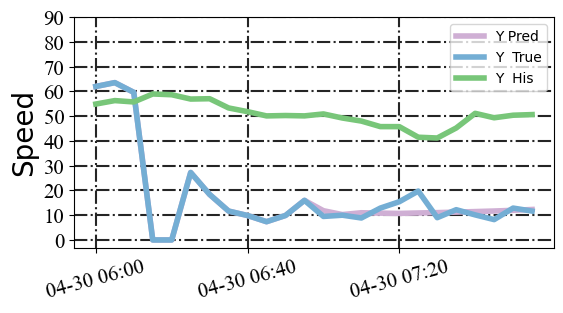

T and His share the same Meta Node.


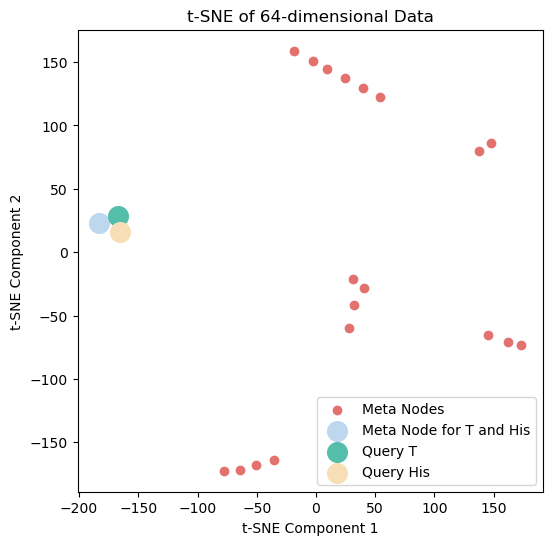

In [10]:
node_index=8
date_index=17376
draw_all(date_index,node_index,data,model,scaler)
# draw_all(date_index,node_index,data,model_woC,scaler)
# draw_all(date_index,node_index,data,model_woD,scaler)
# draw_all(date_index,node_index,data,model_woCD,scaler)

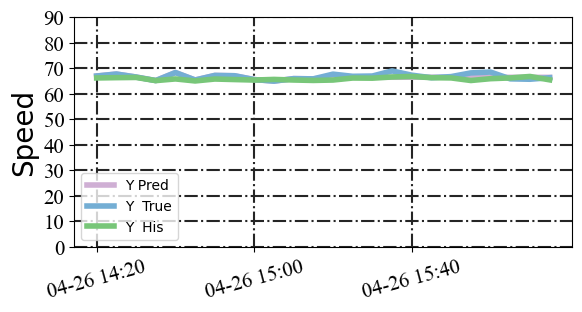

T and His share the same Meta Node.


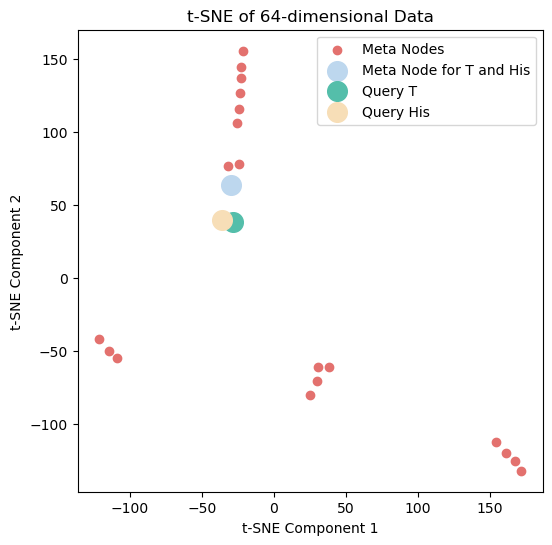

In [11]:
# date_index=16324
# node_index=78
draw_all(16324,78,data,model,scaler)

In [12]:
import time
start_time = time.time()

model.eval()
for i in range(0, 21000):
    test_input=data["x_train"][i:i+1,:,:,:]
    test_input=torch.from_numpy(test_input).float().to(device)
    y=data["y_train"][i:i+1,:,:,:]
    y=torch.from_numpy(y).float().to(device)
    x, x_cov, x_his, y, y_cov, _ = prepare_x_y(test_input, y)
    with torch.no_grad():
        output, h_att, query, pos, neg, mask, real_dis, latent_dis, mask_dis = model(x, x_cov, scaler.transform(x_his), y_cov)
    pos_t=pos.squeeze().cpu().detach()[:1,:,:]
    pos_his=pos.squeeze().cpu().detach()[1:,:,:]
    mask_t=mask.squeeze().cpu().detach()[:1,:,:]
    mask_his=mask.squeeze().cpu().detach()[1:,:,:]
    if not np.array_equal(pos_t, pos_his):
        print(i,node_index)
    if not np.array_equal(mask_t, mask_his):
        print(i,node_index)        
    if i % 1000 == 0:
        elapsed_time = time.time() - start_time
        print(f"Elapsed time after {i} loops: {elapsed_time} seconds")

Elapsed time after 0 loops: 0.035373687744140625 seconds
Elapsed time after 1000 loops: 33.512879610061646 seconds
Elapsed time after 2000 loops: 64.2161123752594 seconds
Elapsed time after 3000 loops: 94.94877076148987 seconds
Elapsed time after 4000 loops: 125.64373707771301 seconds
Elapsed time after 5000 loops: 156.3437943458557 seconds
Elapsed time after 6000 loops: 187.06891798973083 seconds
Elapsed time after 7000 loops: 217.7415030002594 seconds
Elapsed time after 8000 loops: 248.4078562259674 seconds
Elapsed time after 9000 loops: 279.06120443344116 seconds
Elapsed time after 10000 loops: 309.69667744636536 seconds
Elapsed time after 11000 loops: 340.4244840145111 seconds
Elapsed time after 12000 loops: 371.197772026062 seconds
Elapsed time after 13000 loops: 401.8787398338318 seconds
Elapsed time after 14000 loops: 432.64075803756714 seconds
Elapsed time after 15000 loops: 463.4490532875061 seconds
Elapsed time after 16000 loops: 494.1461114883423 seconds
Elapsed time after 1